<a href="https://colab.research.google.com/github/Rutu07/Sentiment-Analysis-Using-BERT/blob/main/Airline_Tweets_Sentiment_Analysis_Using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- GPU (Graphics Processing Unit) enable paralle processing of complex tasks. Lot of computing power is required to train Neural Networks on thousands/millions of records and GPUs provide this computing power. 
- Traditional CPUs are capable of completing task in sequential manner along with their multi-cores, however GPUs process many parts of data simultaneously.

In [ ]:
import torch
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth',200)
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

#library for progress bar
from tqdm import notebook

Runtime->Chane RunTIme-> Select GPU in Hardware Accelrator


In [ ]:
# Checking if GPU is available. 
if torch.cuda.is_available():
  device=torch.device('cuda')

In [ ]:
print(device)
torch.cuda.get_device_name(0)
# Current GPU is Tesla T4

cuda


'Tesla T4'

### Step 2: Installing Hugging Face's Transformers Library
- Hugging face is one of the most popular NLP library and provides a wide range of transformer-based models such as BERT, GPT-2, Roberta, and so on.


In [ ]:
#!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.2 MB/s eta 0:00:00


### Step 3: Installing BertModel 

- BERT uncased: This model was trained on lower case text data. Other types of pre-trained models, can be found at https://huggingface.co/models


In [ ]:
from transformers.models.bert.modeling_bert import BertModel
# Import BERT pretrained module

from transformers import BertModel

#Download uncased bert base model
bert=BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Print BERT arcitecture
print(bert)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

### Step 4: Importing BERT tokenizer
It tencodes text into positional encodings combined with word(contextual) embeddings. The tokenizer version present in transformers library is the fast version.

In [ ]:
from transformers.models.bert.tokenization_bert_fast import BertTokenizerFast
# importing BERT tokenizer 
tokenizer=BertTokenizerFast.from_pretrained('bert-base-uncased',do_lower_case=True)


**Steps occuring in Input Encoding**

1. Tokenization
2. Special Tokens
  * Prepending [CLS] token at the start of the sequence
  * Appneding [SEP] token at the end of the seqence
3. Pad sequences
4. Convert tokens into integers(vector embeddings)
5. Create attention masks to indicate non padded elements.




In [ ]:
text='Jim Henson was a puppeteer'
sentence_id=tokenizer.encode(text,
                             # add special character tokens
                             add_special_tokens=True,
                             # Specifying maximum length for any input sequences
                             max_length=10,
                             # if exceeeding 10, then it will be truncated, if <10, then it will be padded.
                             truncation=True,
                             # add pad tokens to the right side of the sequence
                             pad_to_max_length='right'
                             )
print("Integer Sequence:{}".format(sentence_id))

Integer Sequence:[101, 3958, 27227, 2001, 1037, 13997, 11510, 102, 0, 0]


- [CLS] is represented by 101 where as [SEP] is represented by 102. Two zeros at the end represent padded elements. 

In [ ]:
# converting integers back to text
print("Tokenizer Text: ",tokenizer.convert_ids_to_tokens(sentence_id))

Tokenizer Text:  ['[CLS]', 'jim', 'henson', 'was', 'a', 'puppet', '##eer', '[SEP]', '[PAD]', '[PAD]']


- Note that puppeteer was not a part of Bert tokenizer vocabulary while training. It doesn't have any word embedding for word puppeteer. Hence it was split into known and unknown part as puppet and '##eer'. the tokenizer has embeddings for both the tokens. ## represents that the token is a sub word. This is how BERT tokenizer handles unkwown words.

- Using tokenizer.decode(), this can be decoded back into original sentence

In [ ]:
decoded=tokenizer.decode(sentence_id)
print('Decoded String:{}'.format(decoded))

Decoded String:[CLS] jim henson was a puppeteer [SEP] [PAD] [PAD]


- Masking needs to be done to avoid performing attention on padding token indices.
- mask value=1 for tokens and 0 for unmasked tokens

In [ ]:
att_mask=[int(tok>0) for tok in sentence_id]
print(att_mask)

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]


**Understanding Input and Output of BERT Tokenizer**


- To understand unsqueeze() and squeeze() function: https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch


In [ ]:
# convert lists to tensors
# torch.tensor creates a tensor of given data
sent_id=torch.tensor(sentence_id)
attn_mask=torch.tensor(att_mask)
print('Shape of sentence_id before reshaping is: {}'.format(sent_id.shape))
print('Shape of sentence_id before reshaping is: {}'.format(attn_mask.shape))
print('\n')
# reshaping tensor in form of batch,text length
sent_id=sent_id.unsqueeze(0)
attn_mask=attn_mask.unsqueeze(0)
print('Shape of sentence_id after reshaping is: {}'.format(sent_id.shape))
print('Shape of sentence_id after reshaping is: {}'.format(attn_mask.shape))
print('\n')
# reshaped tensor
print(sent_id)


Shape of sentence_id before reshaping is: torch.Size([10])
Shape of sentence_id before reshaping is: torch.Size([10])


Shape of sentence_id after reshaping is: torch.Size([1, 10])
Shape of sentence_id after reshaping is: torch.Size([1, 10])


tensor([[  101,  3958, 27227,  2001,  1037, 13997, 11510,   102,     0,     0]])


- Here we can see that list of integers has beem converted into pytorch tensor of dimension (1,10)

In [ ]:
# passing integer sequence and attention mask tensor to BERT model
outputs=bert(sent_id,attention_mask=attn_mask)


In [ ]:
# Unpacking the output of BERT model

# all_hidden_states is a collection of all the output vectors/ hidden states at each timestamps or position of the BERT model
all_hidden_states=outputs[0]

print(all_hidden_states.shape)
print(all_hidden_states)

torch.Size([1, 10, 768])
tensor([[[-0.2531,  0.2038, -0.3862,  ..., -0.3034,  0.6197,  0.2373],
         [-0.2323, -0.0044, -0.5479,  ...,  0.0765,  0.8122, -0.4710],
         [ 0.2590,  0.7140, -0.5438,  ..., -0.3774,  0.9987,  0.5400],
         ...,
         [ 0.7873,  0.3299, -0.0351,  ...,  0.2932, -0.5141,  0.0308],
         [-0.5547, -0.3669, -0.1106,  ...,  0.2593,  0.5321, -0.3871],
         [-0.5461, -0.2414, -0.2111,  ...,  0.3100,  0.5863, -0.3467]]],
       grad_fn=<NativeLayerNormBackward0>)


- 1 because we have only one senetence
- 10 because we have maximum of 10 words in it
- 768 is the default dim of BERT output vector where every word out of 10 words is represented into a vector of 768 columns

In [ ]:
# this output contains output vector against the CLS token only (at the first position of BERT model)
# this output vector encodes the entire input sequence 

cls_hidden_state=outputs[1]

print(cls_hidden_state.shape)
print(cls_hidden_state)

torch.Size([1, 768])
tensor([[-0.8767, -0.4109, -0.1220,  0.4494,  0.1945, -0.2698,  0.8316,  0.3127,
          0.1178, -1.0000, -0.1561,  0.6677,  0.9891, -0.3451,  0.8812, -0.6753,
         -0.3079, -0.5580,  0.4380, -0.4588,  0.5831,  0.9956,  0.4467,  0.2863,
          0.3924,  0.6864, -0.7513,  0.9043,  0.9436,  0.8207, -0.6493,  0.3524,
         -0.9919, -0.2295, -0.0742, -0.9936,  0.3698, -0.7558,  0.0792, -0.2218,
         -0.8637,  0.4711,  0.9997, -0.4368,  0.0404, -0.3498, -1.0000,  0.2663,
         -0.8711,  0.0508,  0.0505, -0.1634,  0.1716,  0.4363,  0.4330, -0.0333,
         -0.0416,  0.2206, -0.2568, -0.6122, -0.5916,  0.2569, -0.2622, -0.9042,
          0.3221, -0.2394, -0.2634, -0.3454, -0.0723,  0.0081,  0.8297,  0.2279,
          0.1614, -0.6555, -0.2062,  0.3280, -0.4016,  1.0000, -0.0952, -0.9874,
         -0.0400,  0.0717,  0.3675,  0.3373, -0.3710, -1.0000,  0.4479, -0.1722,
         -0.9917,  0.2677,  0.4844, -0.2207, -0.3207,  0.3715, -0.2171, -0.2522,
       

### Step 5: Data Preparation
#### 5.1 Loading dataset and selecting important columns



In [ ]:
!unzip 'Airline_Tweets.zip'

Archive:  Airline_Tweets.zip
  inflating: Tweets.csv              


In [ ]:
df=pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df.shape

(14640, 15)

- Features of our interest are label column and text column

In [ ]:
df['text'].sample(5)

3923     @united @PGATOUR @NTrustOpen I read that last hashtag as Go F United. Makes sense since they F us by Cancelled Flightling ticketed reservations
10022                 @USAirways Its not just PHL, at BTV today made to deplane because "it's Sunday and we don't know if maintenance will be available"
856                                  @united the aircraft closest to gate was for the other flight and the one closest to our gate was going to Chicago.
966                       @united you Cancelled Flighted our flights for no reason &amp; now we have been on the phone for AN HOUR on our vacation. Why?
6345                                                                                @SouthwestAir when will you have flights for October 2015 available?
Name: text, dtype: object

- Distribution of Tweets (label)


In [ ]:
print(df['airline_sentiment'].value_counts())
print(df['airline_sentiment'].value_counts(normalize=True))

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64
negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64


In [ ]:
# Sabing value counts to a list
class_counts=df['airline_sentiment'].value_counts().to_list()

#### 5.2 Text cleaning
- Removing twitter usernames
- Removing links (starting with https)
- If needed removing hashtags

In [ ]:
def preprocess(text):
  # converting text tolower case
  text=text.lower()
  # remove user mentions
  text=re.sub(r'@[A-Za-z0-9]+','',text)
  # remove hashtags if needed keep for now
  #text=re.sub(r'#[A-Za-z0-9]+','',text)

  # remove links
  text=re.sub(r'http\S+','',text)

  # Split tokens so that extra spaces which were added due to above substitution are removed
  tokens=text.split()

  # join tokens by space
  return ' '.join(tokens)

In [ ]:
# using apply function to apply this preprocess function on each row of the text column
df['cleaned_text']=df['text'].apply(preprocess)

In [ ]:
df.head()[['airline_sentiment','text','cleaned_textb']]

,airline_sentiment,text,cleaned_text
0,neutral,@VirginAmerica What @dhepburn said.,what said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,i didn't today... must mean i need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it,and it's a really big bad thing about it


In [ ]:
# Saving cleaned text and labels to variables
text=df['cleaned_text'].values
labels=df['airline_sentiment'].values

In [ ]:
print(type(text))
print(type(labels))
print(text.shape)
print(labels.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(14640,)
(14640,)


In [ ]:
text[50:55]

array(['is flight 769 on it\'s way? was supposed to take off 30 minutes ago. website still shows "on time" not "in flight". thanks.',
       'julie andrews all the way though was very impressive! no to',
       'wish you flew out of atlanta... soon?',
       'julie andrews. hands down.',
       'will flights be leaving dallas for la on february 24th?'],
      dtype=object)

In [ ]:
labels[50:55]

array(['neutral', 'positive', 'neutral', 'neutral', 'neutral'],
      dtype=object)

#### 5.3 Preparing input and output data 
- **Preparing target input**


In [ ]:
# Using label encoder, convert textual labels (positive, negative, neutral) into numners
le=LabelEncoder()

#fit and transform target strings to a number
labels=le.fit_transform(labels)

In [ ]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
labels

array([1, 2, 1, ..., 1, 0, 1])

- Visualize length of tweets


Text(0, 0.5, 'Count of sentences')

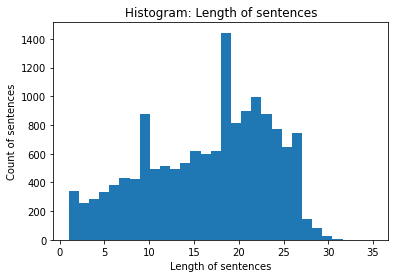

In [ ]:
num=[len(i.split()) for i in text]
plt.hist(num,bins=30)
plt.title('Histogram: Length of sentences')
plt.xlabel('Length of sentences')
plt.ylabel('Count of sentences')

- It can be observed that most of the sentences (~95%) have length of 25 words. Hence, we select max_length as 25 for all the tweets in our dataset. 
- All the sequences will be paddded to 25.
- How to decide?
If you choose too big number, then most of the positions in your sequence will have padded tokens. So choose a number neer to your max lenght of text sequence

- **Preparing Textual Input**

In [ ]:
max_len=25 # This is a hyper parameter which can be tuned

- Using bert tokenizer, convert text sequences into numerical vectors

In [ ]:
# Create an empty list to save integer sequence
sent_id=[]

# iterate over each tweet and encode it using bert tokenizer
for i in notebook.tqdm(range(len(text))):
  encoded_sent=tokenizer.encode(text[i],
                                add_special_tokens=True,
                                max_length= max_len,
                                truncation=True,
                                pad_to_max_length='right'
                                )
  
  # save integer sequence to a list
  sent_id.append(encoded_sent)

  0%|          | 0/14640 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
print(text[0])

what said.


In [ ]:
print(sent_id[0])

[101, 2054, 2056, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


- Create Attention masks

In [ ]:
attention_mask=[]

for sent in sent_id:
  attn_mask=[int(token_id>0) for token_id in sent]
  attention_mask.append(attn_mask)

#### Step 5: Training and Validation Data